# Warm-starting quantum optimization

## Introduction

Optimization problems with integer variables or constraints are often hard to solve. For example, the Quadratic Unconstrained Binary Optimization (QUBO) problem, i.e.

\begin{align}
\min_{x\in\{0,1\}^n}x^T\Sigma x + \mu^Tx,
\end{align}

is NP-Hard. Here, $\Sigma$ is an $n\times n$ matrix and $x$ is a vector of $n$ binary variables. Note that we could have added the linear term $\mu$ to the diagonal as $x_i^2=x_i$ for $x_i\in\{0, 1\}$. While QUBOs are hard to solve there exists many ways to relax them to problems that are easier to solve.
For example, if $\Sigma$ is semi-definite positive the QUBO can be relaxed to a Quadratic Program 

\begin{align}
\min_{x\in[0,1]^n}x^T\Sigma x,
\end{align}

which becomes easy to solve as $x$ now represents $n$ continuous variables bound to the range $[0, 1]$.
Such relaxations can be leveraged to warm-start quantum optimization algorithms as shown in [1].

## References

[1] [D. J. Egger, J Marecek, S. Woerner, *Warm-starting quantum optimization*, arXiv:2009.10095](http://arxiv.org/abs/2009.10095)

In [1]:
import numpy as np

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit.optimization import QuadraticProgram

## Preliminaries: relaxing QUBOs

First, we show how to relax a QUBO built with a semi-definite positive matrix to obtain an easy-to-solve QP.

In [2]:
def create_qp(mu: np.array, sigma: np.array, continuous: bool = False, total: int = 3):
    """
    Solve the quadratic program using docplex.
    """
    
    mdl = Model()
    
    if continuous:
        x = [mdl.continuous_var(lb=0., ub=1.0, name='x%s' % i) for i in range(len(sigma))]
    else:
        x = [mdl.binary_var('x%s' % i) for i in range(len(sigma))]
    
    objective = mdl.sum([mu[i]*x[i] for i in range(len(mu))])
    objective -= 2*mdl.sum([sigma[i, j]*x[i]*x[j] for i in range(len(mu)) for j in range(len(mu))])
    mdl.maximize(objective)
    cost = mdl.sum(x)
    mdl.add_constraint(cost == total)
    
    return mdl, x

For this example, we use a positive semi-definite matrix $\Sigma$ and a linear term $\mu$ as defined below.

In [3]:
mu = np.array([3.418,  2.0913,  6.2415,  4.4436, 10.892 ,  3.4051])
sigma = np.array([[ 1.07978412,  0.00768914,  0.11227606, -0.06842969, -0.01016793, -0.00839765],
                  [ 0.00768914,  0.10922887, -0.03043424, -0.0020045 ,  0.00670929, 0.0147937 ],
                  [ 0.11227606, -0.03043424,  0.985353  ,  0.02307313, -0.05249785, 0.00904119],
                  [-0.06842969, -0.0020045 ,  0.02307313,  0.6043817 ,  0.03740115, -0.00945322],
                  [-0.01016793,  0.00670929, -0.05249785,  0.03740115,  0.79839634, 0.07616951],
                  [-0.00839765,  0.0147937 ,  0.00904119, -0.00945322,  0.07616951, 1.08464544]])

Using DOCPLEX we build a model with binary variables.

In [4]:
qubo, x = create_qp(mu, sigma, continuous=False)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Maximize
 obj: 3.418000000000 x0 + 2.091300000000 x1 + 6.241500000000 x2
      + 4.443600000000 x3 + 10.892000000000 x4 + 3.405100000000 x5 + [
      - 4.319136480000 x0^2 - 0.061513120000 x0*x1 - 0.898208480000 x0*x2
      + 0.547437520000 x0*x3 + 0.081343440000 x0*x4 + 0.067181200000 x0*x5
      - 0.436915480000 x1^2 + 0.243473920000 x1*x2 + 0.016036000000 x1*x3
      - 0.053674320000 x1*x4 - 0.118349600000 x1*x5 - 3.941412000000 x2^2
      - 0.184585040000 x2*x3 + 0.419982800000 x2*x4 - 0.072329520000 x2*x5
      - 2.417526800000 x3^2 - 0.299209200000 x3*x4 + 0.075625760000 x3*x5
      - 3.193585360000 x4^2 - 0.609356080000 x4*x5 - 4.338581760000 x5^2 ]/2
Subject To
 c1: x0 + x1 + x2 + x3 + x4 + x5 = 3

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1
 0 <= x5 <= 1

Binaries
 x0 x1 x2 x3 x4 x5
End



Binary problems of this sort hard hard to solve but can be solved if the problem instance is small enough. Our example above has as solution

In [5]:
qubo.solve().get_values(x)

[0, 0, 1.0, 1.0, 1.0, 0]

which corresponds to the following objective value:

In [11]:
qubo.solve().get_objective_value()

16.7689322

We can create a relaxation of this problem in which the variables are no longer binary.

In [12]:
qp, x = create_qp(mu, sigma, continuous=True)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model3

Maximize
 obj: 3.418000000000 x0 + 2.091300000000 x1 + 6.241500000000 x2
      + 4.443600000000 x3 + 10.892000000000 x4 + 3.405100000000 x5 + [
      - 4.319136480000 x0^2 - 0.061513120000 x0*x1 - 0.898208480000 x0*x2
      + 0.547437520000 x0*x3 + 0.081343440000 x0*x4 + 0.067181200000 x0*x5
      - 0.436915480000 x1^2 + 0.243473920000 x1*x2 + 0.016036000000 x1*x3
      - 0.053674320000 x1*x4 - 0.118349600000 x1*x5 - 3.941412000000 x2^2
      - 0.184585040000 x2*x3 + 0.419982800000 x2*x4 - 0.072329520000 x2*x5
      - 2.417526800000 x3^2 - 0.299209200000 x3*x4 + 0.075625760000 x3*x5
      - 3.193585360000 x4^2 - 0.609356080000 x4*x5 - 4.338581760000 x5^2 ]/2
Subject To
 c1: x0 + x1 + x2 + x3 + x4 + x5 = 3

Bounds
       x0 <= 1
       x1 <= 1
       x2 <= 1
       x3 <= 1
       x4 <= 1
       x5 <= 1
End



The solution of this continuous relaxation is different from the solution to the binary problem but can be used to warm-start a solver when dealing with the binary problem.

In [13]:
c_stars = qp.solve().get_values(x)
c_stars

[0.1690954976403224,
 5.3235159784064565e-09,
 0.9653848143204397,
 0.727172427736337,
 0.9999999996719753,
 0.1383472553074099]

## QAOA

Here, we illustrate how to warm-start the quantum approximate optimization algorithm (QAOA) by leveraging the relaxed problem shown above. 

### Standard QAOA

First, we use standard QAOA to solve the QUBO. To do this, we convert the QUBO to Qiskit's QuadraticProgram class (note that the resulting problem is still a binary problem).

In [14]:
qubo_ = QuadraticProgram()
qubo_.from_docplex(qubo)

In [15]:
aqua_globals.random_seed = 10598
quantum_instance = QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                   seed_simulator=aqua_globals.random_seed,
                                   seed_transpiler=aqua_globals.random_seed)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
exact_mes = NumPyMinimumEigensolver()

In [16]:
qaoa = MinimumEigenOptimizer(qaoa_mes)

In [18]:
qaoa_result = qaoa.solve(qubo_)
print(qaoa_result)

optimal function value: 16.768932200000002
optimal value: [0. 0. 1. 1. 1. 0.]
status: SUCCESS


### Warm-start QAOA

Next, we compare this result to a warm-start QAOA in which we use the solution to the continuous relaxation of the problem. First, we create the initial state 

\begin{align}
|\phi^*\rangle=\bigotimes_{i=0}^{n-1}R_y(\theta_i)|0\rangle_n .
\end{align}

which is given by applying $R_y$ rotations with an angle $\theta=2\arcsin(\sqrt{c^*_i})$ that depends on the solution to the relaxed problem.
Here, $c^*_i$ the value of variable $i$ of the relaxed problem.

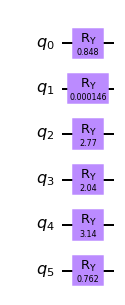

In [19]:
from qiskit import QuantumCircuit

thetas = [2*np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)
    
init_qc.draw(output='mpl')

Next, we create the mixer operator for QAOA. When warm-starting QAOA we must ensure that the mixer operator has the initial state as gound state. We therefore chose the Hamiltonian

\begin{align}
H_{M,i}^{(ws)}=
\begin{pmatrix}
2c_i^*-1 & -2\sqrt{c_i^*(1-c_i^*)} \\
-2\sqrt{c_i^*(1-c_i^*)} & 1-2c_i^*
\end{pmatrix}
\end{align}

as mixer operator for qubit $i$. Once multiplied by $-i\beta$ and exponentiated this mixer produces the following mixer circuit.

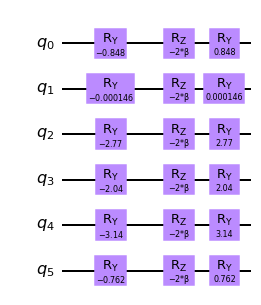

In [20]:
from qiskit.circuit import Parameter

beta = Parameter('β')

ws_mixer = QuantumCircuit(len(sigma))
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2*beta, idx)
    ws_mixer.ry(theta, idx)
    
ws_mixer.draw(output='mpl')

The initial state and mixer operator can then be passed to QAOA.

In [21]:
ws_qaoa_mes = QAOA(quantum_instance=quantum_instance, 
                   initial_state=init_qc, 
                   mixer=ws_mixer,
                   initial_point=[0., 1.])

In [22]:
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

In [23]:
ws_qaoa_result = ws_qaoa.solve(qubo_)
print(ws_qaoa_result)

optimal function value: 16.768932200000002
optimal value: [0. 0. 1. 1. 1. 0.]
status: SUCCESS


### Analysis

Both results appear to give the same result. However, when we look at the underlying probability distribution we observe that the warm-start QAOA has a much higher probability of sampling the optimal solution.

In [24]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        if sum(s.x) == 3:
            qaoa_res.append((''.join([str(int(_)) for _ in s.x]), s.fval, s.probability))

    res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]
            
    return [(_[0] + f': value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%') for _ in res]

format_qaoa_samples(qaoa_result.samples)

['001110: value: 16.769, probability: 2.6%',
 '011010: value: 15.744, probability: 1.1%',
 '001011: value: 14.671, probability: 1.7%',
 '101010: value: 14.626, probability: 1.7%',
 '010110: value: 14.234, probability: 1.7%',
 '100110: value: 13.953, probability: 4.7%',
 '000111: value: 13.349, probability: 0.0%',
 '110010: value: 12.410, probability: 0.4%',
 '010011: value: 12.013, probability: 4.0%',
 '100011: value: 11.559, probability: 1.5%']

In [25]:
format_qaoa_samples(ws_qaoa_result.samples)

['001110: value: 16.769, probability: 51.8%',
 '001011: value: 14.671, probability: 7.4%',
 '101010: value: 14.626, probability: 8.6%',
 '100110: value: 13.953, probability: 0.3%',
 '000111: value: 13.349, probability: 0.8%',
 '100011: value: 11.559, probability: 0.0%']

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright